# Pixel-wise Image Segmentation on the Pascal VOC 2012 Dataset

In [1]:
%matplotlib inline
import tensorflow as tf
import keras
import numpy as np
import os

from matplotlib import pyplot
from matplotlib.pyplot import imshow

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
# use only half of available GPU RAM
config.gpu_options.per_process_gpu_memory_fraction = 0.7
set_session(tf.Session(config=config))

The post at https://thegradient.pub/semantic-segmentation/ shows a few possibilities for image segmentation.

In [3]:
#https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/datasets/pascal_voc.py
#https://github.com/fizyr/keras-retinanet/blob/master/keras_retinanet/preprocessing/pascal_voc.py

voc_classes = {
    'aeroplane'   : 0,
    'bicycle'     : 1,
    'bird'        : 2,
    'boat'        : 3,
    'bottle'      : 4,
    'bus'         : 5,
    'car'         : 6,
    'cat'         : 7,
    'chair'       : 8,
    'cow'         : 9,
    'diningtable' : 10,
    'dog'         : 11,
    'horse'       : 12,
    'motorbike'   : 13,
    'person'      : 14,
    'pottedplant' : 15,
    'sheep'       : 16,
    'sofa'        : 17,
    'train'       : 18,
    'tvmonitor'   : 19
}


## 1. Downloading the Dataset

In [4]:
# retrieve the VOC dataset
# PASCAL VOC 2012 (http://host.robots.ox.ac.uk/pascal/VOC/voc2012/).
# https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/datasets/pascal_voc.py
# https://github.com/lukas/Keras-FCN-1
# https://github.com/oyam/Semantic-Segmentation-using-Adversarial-Networks
download = False

In [5]:
def untar(filename, destination_folder, is_zipped=False):
    return "tar -C %s -%sxvf %s" % (destination_folder, "z" if is_zipped else "", filename)

In [6]:
# original PASCAL VOC 2012
# https://github.com/oyam/Semantic-Segmentation-using-Adversarial-Networks/blob/master/setup/download_dataset.py
if download:
    !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar # 2 GB
    !mkdir data
    untar("VOCtrainval_11-May-2012.tar", "data", is_zipped=False)
    !tar -C data -xvf VOCtrainval_11-May-2012.tar

## 2. Loading the dataset

### 2.1 Setting the data paths

In [7]:
base_path = "data/VOCdevkit/VOC2012/"

x_subpath = "JPEGImages"
y_class_subpath = "SegmentationClass"
y_obj_subpath = "SegmentationObject"

img_path = os.path.join(base_path, x_subpath)
segmentation_class_path = os.path.join(base_path, y_class_subpath) 
segmentation_obj_path = os.path.join(base_path, y_obj_subpath)

### 2.2 Set a common size for all dataset images

In [8]:
# set the expected size for the dataset images
img_w = 512 # 512/2/2/2/2/2 = 16 px
img_h = 320 # 304/2/2/2/2/2 = 10 px
target_size =(img_w,img_h)

### 2.3 Extracting the file names from the data

In [9]:
import os
img_filenames = os.listdir(img_path)
print "Total image files", len(img_filenames)
img_filenames[:2]
extension_sources = ".jpg"
img_filenames = [f.split(".")[0] for f in img_filenames]

Total image files 17125


Group images by type, since i noticed that some did not match across folders:

In [10]:
segmentation_class_filenames = os.listdir(segmentation_class_path)
segmentation_obj_filenames = os.listdir(segmentation_obj_path)
print "segmentation_class_filenames", len(segmentation_class_filenames), "example:", segmentation_class_filenames[:2]
print "segmentation_obj_filenames", len(segmentation_obj_filenames), "example:", segmentation_obj_filenames[:2]

extension_targets = ".png"
segmentation_class_filenames = [f.split(".")[0] for f in segmentation_class_filenames]
segmentation_obj_filenames = [f.split(".")[0] for f in segmentation_obj_filenames]

segmentation_class_filenames 2913 example: ['2010_003894.png', '2007_003190.png']
segmentation_obj_filenames 2913 example: ['2010_003894.png', '2007_003190.png']


Select only those images common for all datasets:

In [11]:
img_filenames = [i for i in img_filenames if i in segmentation_class_filenames and i in segmentation_obj_filenames]
print "Raw images", len(img_filenames)

Raw images 2913


### 2.4 Splitting in test and train sets

In [12]:
from sklearn.model_selection import train_test_split
seed = 1234
train, test = train_test_split(img_filenames, test_size=0.33, random_state=seed)
print "train size", len(train)
print "test size", len(test)

train size 1951
test size 962


### 2.6 Load the dataset
We define hereby functions to load the dataset either directly in RAM in a array format, which might result too heavy given limited memory requirements, or as batch generator which can be directly passed to the model training function. Let's then select firstly hereby how to carry out this process:

Should we use a python generator instead of a batch load of the entire set?

In [13]:
train_using_generator = True

Do we want the class (true) or the object segmentation?

In [14]:
segmentation_class = False

#### 2.6.1 Load dataset completely

Define a function to load and resize the entire dataset (heavy!):

In [15]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator

def load_from_path(path, resize_to=None):
    img = load_img( path )
    if resize_to is not None:
        #print "Resized from", img.width, img.height, "to", resize_to[0], resize_to[1]
        img = img.resize((resize_to[0], resize_to[1]))
    return img_to_array( img )

def load_resize(path, resize_to):
    img = tf.image.decode_jpeg(path)
    print "img_type", type(img)
    resized_img = tf.image.resize_images(img, (resize_to[0], resize_to[1]))
    print "resized_img_type", type(resized_img)
    resized_img = tf.cast(resized_img, np.uint8).eval()
    
    #return img_to_array( resized_img )
    return resized_img

def get_train_test_sets(x_train,
                        x_test,
                        segmentation_class_files_train,
                        segmentation_class_files_test,
                        segmentation_obj_files_train,
                        segmentation_obj_files_test,
                        segmentation_class=False):
    """
        Populate x_train and x_test with all images available in the dataset (memory consuming)
    """
    for img_name in train: #[:10]:
        x_train.append(load_from_path(os.path.join(img_path,
                                                   img_name+extension_sources),
                                      resize_to=target_size ) )
        if segmentation_class:
            segmentation_class_files_train.append(load_from_path(os.path.join(segmentation_class_path,
                                                                              img_name+extension_targets),
                                                                 resize_to=target_size) )
        else:
            segmentation_obj_files_train.append(load_from_path(os.path.join(segmentation_obj_path,
                                                                            img_name+extension_targets),
                                                               resize_to=target_size) )

    for img_name in test: #[:10]:
        x_test.append(load_from_path(os.path.join(img_path,
                                                  img_name+extension_sources),
                                    resize_to=target_size))
        if segmentation_class:
            segmentation_class_files_test.append(load_from_path(os.path.join(segmentation_class_path,
                                                                             img_name+extension_targets),
                                                                resize_to=target_size) )
        else:
            segmentation_obj_files_test.append(load_from_path(os.path.join(segmentation_obj_path, 
                                                                           img_name+extension_targets),
                                                              resize_to=target_size) )

    x_train = np.asarray(x_train)
    print x_train.shape
    x_test = np.asarray(x_test)

    segmentation_class_files_train = np.asarray(segmentation_class_files_train)
    print segmentation_class_files_train.shape
    segmentation_class_files_test = np.asarray(segmentation_class_files_test)
    print segmentation_class_files_test.shape

    segmentation_obj_files_train = np.asarray(segmentation_obj_files_train)
    print segmentation_obj_files_train.shape
    segmentation_obj_files_test = np.asarray(segmentation_obj_files_test)
    print segmentation_obj_files_test.shape
    
    return x_train, x_test, segmentation_class_files_train, segmentation_class_files_test, segmentation_obj_files_train, segmentation_obj_files_test
    
if not train_using_generator:
    x_train = [] 
    x_test = [] 

    segmentation_class_files_train = [] 
    segmentation_class_files_test = []

    segmentation_obj_files_train = []
    segmentation_obj_files_test = []
    
    x_train, x_test, segmentation_class_files_train, segmentation_class_files_test, segmentation_obj_files_train, segmentation_obj_files_test = get_train_test_sets(x_train, x_test, segmentation_class_files_train, segmentation_class_files_test, segmentation_obj_files_train, segmentation_obj_files_test, segmentation_class=False)

In [16]:
if not train_using_generator:
    print'x_train shape:', x_train.shape

    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        imshow(x_train[i])
        #imgplot = pyplot.imshow(x_train[i])

In [17]:
if not train_using_generator:
    print'segmentation_obj_files_train shape:', segmentation_obj_files_train.shape

    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        imshow(segmentation_obj_files_train[i])
        #imgplot = pyplot.imshow(x_train[i])

#### 2.6.2 Load dataset using Python generators (lightweight)

To minimize the memory that would be necessary to load the entire dataset, we use Python generators to only return batch_size subsets of the dataset during the training process. To achieve this, we use the file names identified when splitting in test and train to move the original images and their related target (i.e., segmented class or object) to a directory structure as follows:
* a "Preprocessed" folder is created as destination path for the preprocessed images
* a "train" directory is created along with a "test" directory
* for both "train" and "test" we have the respective "x" (i.e., original) and "y" (i.e., segmented) images
* the ImageDataGenerator requires a bunch of folders (one for each class) to allow for the flow_from_directory method, we therefore create an "all_classes" folder in each of the mentioned data folders (i.e., train/x, train/y, test/x, test/y) to group them all

In [18]:
def get_target_paths(destination_path):
    """
        returns the paths to be used to store the train and test data when rearranging the initial dataset
    """
    target_x_train = os.path.join(destination_path, "train", "x")
    target_y_train = os.path.join(destination_path, "train", "y")
    target_x_test = os.path.join(destination_path, "test", "x")
    target_y_test = os.path.join(destination_path, "test", "y")
    return target_x_train, target_y_train, target_x_test, target_y_test
    
def rearrange_set(train, test, 
                  common_source_path, 
                  x_subpath, y_subpath, destination_path,
                  subset = None,
                  extension_sources = ".jpg", extension_targets = ".png"):
    """
        Create a copy of the initial dataset, so as to have the split train and test in different folders
    """
    # set paths
    source_x = os.path.join(common_source_path, x_subpath)
    source_y = os.path.join(common_source_path, y_subpath)
    
    target_x_train, target_y_train, target_x_test, target_y_test = get_target_paths(destination_path)
    target_x_train = os.path.join(target_x_train, "all_classes")
    target_y_train = os.path.join(target_y_train, "all_classes")
    target_x_test = os.path.join(target_x_test, "all_classes")
    target_y_test = os.path.join(target_y_test, "all_classes")
    
    # create destination_path if it does not yet exist
    if not os.path.exists(destination_path): # os.path.isdir(destination_path):
        # create destination folders
        os.makedirs(target_x_train)
        os.makedirs(target_y_train)
        os.makedirs(target_x_test)
        os.makedirs(target_y_test)
    # we need to copy the images from x_path to destination_path/x_path
    from shutil import copyfile
    # copy all train images
    for t in train[:subset]:
        # copy t for x_train and y_train to the target path
        sfx = os.path.join(source_x, t+extension_sources)
        tfx = os.path.join(target_x_train, t+extension_sources)
        sfy = os.path.join(source_y, t+extension_targets)
        tfy = os.path.join(target_y_train, t+extension_targets)
        #print "copying from ", sfx, "to", target_x_train
        copyfile(sfx, tfx)
        #print "copying from ", sfy, "to", target_y_train
        copyfile(sfy, tfy)
    # copy all test images
    for t in test[:subset]:
        # copy t for x_test and y_test to the target path
        sfx = os.path.join(source_x, t+extension_sources)
        tfx = os.path.join(target_x_test, t+extension_sources)
        sfy = os.path.join(source_y, t+extension_targets)
        tfy = os.path.join(target_y_test, t+extension_targets)
        #print "copying from ", sfx, "to", target_x_test
        copyfile(sfx, tfx)
        #print "copying from ", sfy, "to", target_y_test
        copyfile(sfy, tfy)

Below we call the rearrange_set to move the test and train images according to the split set previously calculated. The subset parameter can be used to limit the process to only a specific number of images.

In [19]:
# path where to store the new dataset
destination_path = os.path.join(base_path,"Preprocessed")    

target_x_train, target_y_train, target_x_test, target_y_test = get_target_paths(destination_path)
if False:
    # rearrange images so that the files are in specific folders for test and train data
    rearrange_set(train, test, 
                  subset=None, # limit the amount of images to copy from the initial set (no limit when None)
                  common_source_path=base_path,
                  x_subpath=x_subpath, 
                  y_subpath=y_class_subpath if segmentation_class else y_obj_subpath, 
                  destination_path=destination_path)

In [20]:
!ls data/VOCdevkit/VOC2012/Preprocessed/train/x/all_classes

2007_000032.jpg  2008_000544.jpg  2009_001535.jpg  2010_002900.jpg
2007_000033.jpg  2008_000567.jpg  2009_001536.jpg  2010_002902.jpg
2007_000042.jpg  2008_000573.jpg  2009_001544.jpg  2010_002921.jpg
2007_000061.jpg  2008_000578.jpg  2009_001625.jpg  2010_002929.jpg
2007_000063.jpg  2008_000588.jpg  2009_001640.jpg  2010_002935.jpg
2007_000068.jpg  2008_000630.jpg  2009_001651.jpg  2010_002937.jpg
2007_000121.jpg  2008_000645.jpg  2009_001663.jpg  2010_002938.jpg
2007_000123.jpg  2008_000666.jpg  2009_001683.jpg  2010_002939.jpg
2007_000129.jpg  2008_000673.jpg  2009_001684.jpg  2010_003010.jpg
2007_000170.jpg  2008_000676.jpg  2009_001687.jpg  2010_003014.jpg
2007_000241.jpg  2008_000696.jpg  2009_001690.jpg  2010_003017.jpg
2007_000250.jpg  2008_000700.jpg  2009_001693.jpg  2010_003060.jpg
2007_000256.jpg  2008_000711.jpg  2009_001724.jpg  2010_003062.jpg
2007_000323.jpg  2008_000733.jpg  2009_001731.jpg  2010_003088.jpg
2007_000333.jpg  2008_000760.jpg  2009_001735.jpg  2010_003097

Let's now define functions to load the rearranged data:

In [21]:
def get_imageset_batch_generator(x_path, y_path, resize_to, batch_size=1, seed=1234):
    """
        Return a generator for the raw images (x) and the target (y)
        Each time the function is created a new generator is created, to return batch_size images
    """
    # https://keras.io/preprocessing/image/#flow_from_directory
    print "Inspecting", x_path, "and", y_path
    datagenerator = ImageDataGenerator()
    #"categorical" will be 2D one-hot encoded labels,
    #"binary" will be 1D binary labels, 
    #"sparse" will be 1D integer labels,
    #"input" will be images identical to input images (mainly used to work with autoencoders).
    #"None, no labels are returned (just batching)
    x_gen = datagenerator.flow_from_directory(x_path, 
                                             target_size=(resize_to[1], resize_to[0]), 
                                              color_mode='rgb',
                                              classes=None, 
                                              class_mode=None,
                                              batch_size=batch_size, 
                                              shuffle=True, 
                                              seed=seed)
    y_gen = datagenerator.flow_from_directory(y_path, 
                                              target_size=(resize_to[1], resize_to[0]), 
                                              color_mode='rgb',
                                              classes=None, 
                                              class_mode=None,
                                              batch_size=batch_size, 
                                              shuffle=True, 
                                              seed=seed)
    return x_gen, y_gen

from itertools import izip
def zip_xy_gens(x_gen, y_gen):
    """
        Return a generator from the 2 individual generators
    """
    for x, y in izip(x_gen, y_gen):
        yield x, y

In [22]:
# set the batch_size for the example
batch_size = 5

In [23]:
# target_x_train, target_y_train, target_x_test, target_y_test
x_train_gen, y_train_gen = get_imageset_batch_generator(x_path=target_x_train, y_path=target_y_train,
                                                        resize_to=target_size,
                                                        batch_size=batch_size, 
                                                        seed=seed)

Inspecting data/VOCdevkit/VOC2012/Preprocessed/train/x and data/VOCdevkit/VOC2012/Preprocessed/train/y
Found 1951 images belonging to 1 classes.
Found 1951 images belonging to 1 classes.


Hereby is an example from the pre-processed dataset:

ims size 2
ims[0] (5, 320, 512, 3)
ims[1] (5, 320, 512, 3)


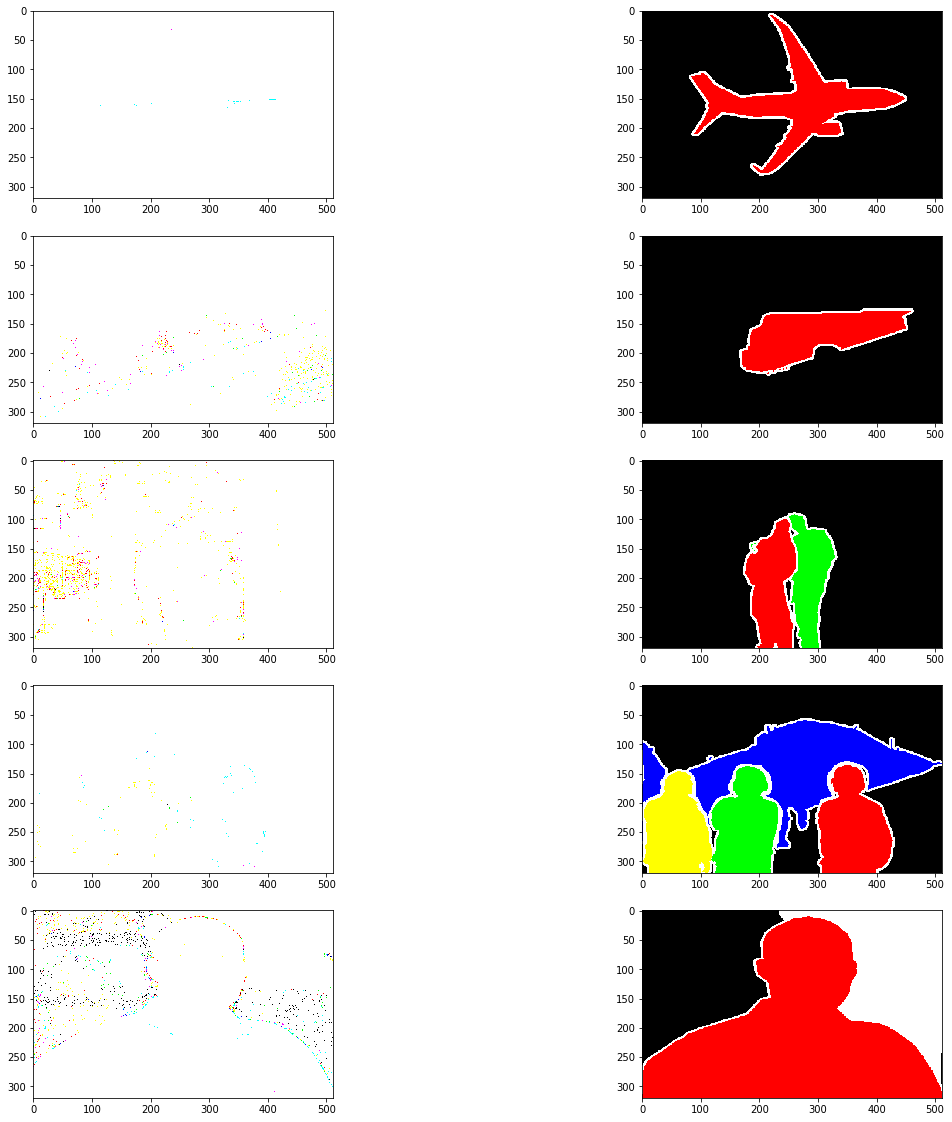

In [24]:
ims = zip_xy_gens(x_train_gen, y_train_gen).next()
print "ims size", len(ims)
for i, v in enumerate(ims):
    print "ims["+str(i)+"]", ims[i].shape

fig=pyplot.figure(figsize=(20,20))

for r in range(batch_size):
    for c in range(len(ims)):
        fig.add_subplot(batch_size, len(ims), 1+r*len(ims)+c)
        imshow(ims[c][r])

As visible, each time next is called on the overall generator, a batch of batch_size elements is simultaneously returned from the individual generators i) x_train_gen and ii) y_train_gen. We accordingly have:
* ims[0] i.e. x_train_gen
* ims[1] i.e. y_train_gen

Another possibility is to use keras.utils.sequence which according to the Keras documentation (https://keras.io/utils/#sequence) offer a safer way to do multiprocessing, since this guarantees that the network will only train once on each sample per epoch which is not the case with generators. We follow below the example provided at https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly and adapt it to the Image Segmentation example we are currently following. The sequence is provided with the list of filenames that constitute the set and a batch_size batch will be returned by loading the previously preprocessed images directly from disk.

In [50]:
from skimage.io import imread
from skimage.transform import resize

from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator

class ImageGenerator(keras.utils.Sequence):
    def __init__(self, 
                 paths,
                 filenames, 
                 input_size=(32,32,32),
                 output_size=(32,32,32),
                 batch_size=32, 
                 extension_x=".jpg",
                 extension_y=".png",
                 resize_to=None,
                 shuffle=True):
        self.paths = paths
        self.filenames = filenames
        self.input_size=input_size
        self.output_size=output_size
        self.batch_size = batch_size
        self.extension_x = extension_x
        self.extension_y = extension_y
        self.resize_to = resize_to
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def on_epoch_end(self):
        """
            Triggered before and after each epoch, updates index order
        """
        self.indexes = np.arange(len(self.filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        """
            To make sure the whole dataset is used for each epoch.
            The number of batches is the number of data entries over the batch size
        """
        #return int(np.floor(len(self.filenames) / self.batch_size))
        #return int(np.ceil(len(self.filenames) / float(self.batch_size)))
        return 1
    
    def __getitem__(self, index):
        """Return one data batch"""
        # Randomly select a batch of indexes from the index list
        indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        # Find filenames having those indexes
        filenames_batch = [self.filenames[k] for k in indexes]
        # Generate one batch for those filenames
        X, y = self.__data_generation(filenames_batch)
        return X, y
    
    def __load_and_resize__(self, path):
        # mode 1
        img_tmp = imread(path)
        if self.resize_to is not None:
            img_tmp = resize(img_tmp, self.resize_to)
        return img_tmp
        
        """
        # mode 2
        # this seems to be lot slower than mode 1, no clue why, it is even keras based
        img_tmp = load_img( path )
        if self.resize_to is not None:
            img_tmp = img_tmp.resize((self.resize_to[0], self.resize_to[1]))
        return img_to_array( img )
        """
        
        """
        # mode 3
        img_tmp = tf.image.decode_jpeg(path)
        print "img_type", type(img_tmp)
        resized_img = tf.image.resize_images(img_tmp, (self.resize_to[0], self.resize_to[1]))
        print "resized_img_type", type(resized_img)
        resized_img = tf.cast(resized_img, np.uint8).eval()
        #return img_to_array( resized_img )
        return resized_img
        """        
    
    def __data_generation(self, filenames_temp):
        """Generates batch_size samples """
        # generate resulting data with shape
        # (batch_size, input_size[:]) and (batch_size, output_size[:])
        x = np.empty((self.batch_size,)+ self.input_size)
        y = np.empty((self.batch_size,)+ self.output_size)

        # Load data from the filename list for both source and targe data
        for i, filename in enumerate(filenames_temp):
            # load and resize source image
            x[i] = self.__load_and_resize__(os.path.join(self.paths["x"], filename+ self.extension_x))

            # load and resize target image
            y[i] = self.__load_and_resize__(os.path.join(self.paths["y"], filename+ self.extension_y))

        return x, y

Prepare a dictionary to contain all paths for the ImageGenerator:

In [51]:
paths_train = dict()
paths_train["x"] = os.path.join(target_x_train, "all_classes")
paths_train["y"] = os.path.join(target_y_train, "all_classes")
paths_test = dict()
paths_test["x"] = os.path.join(target_x_test, "all_classes")
paths_test["y"] = os.path.join(target_y_test, "all_classes")

 batch has length 2
batch has shape (2, 320, 512, 3)
ims[0] (5, 320, 512, 3)
ims[1] (5, 320, 512, 3)


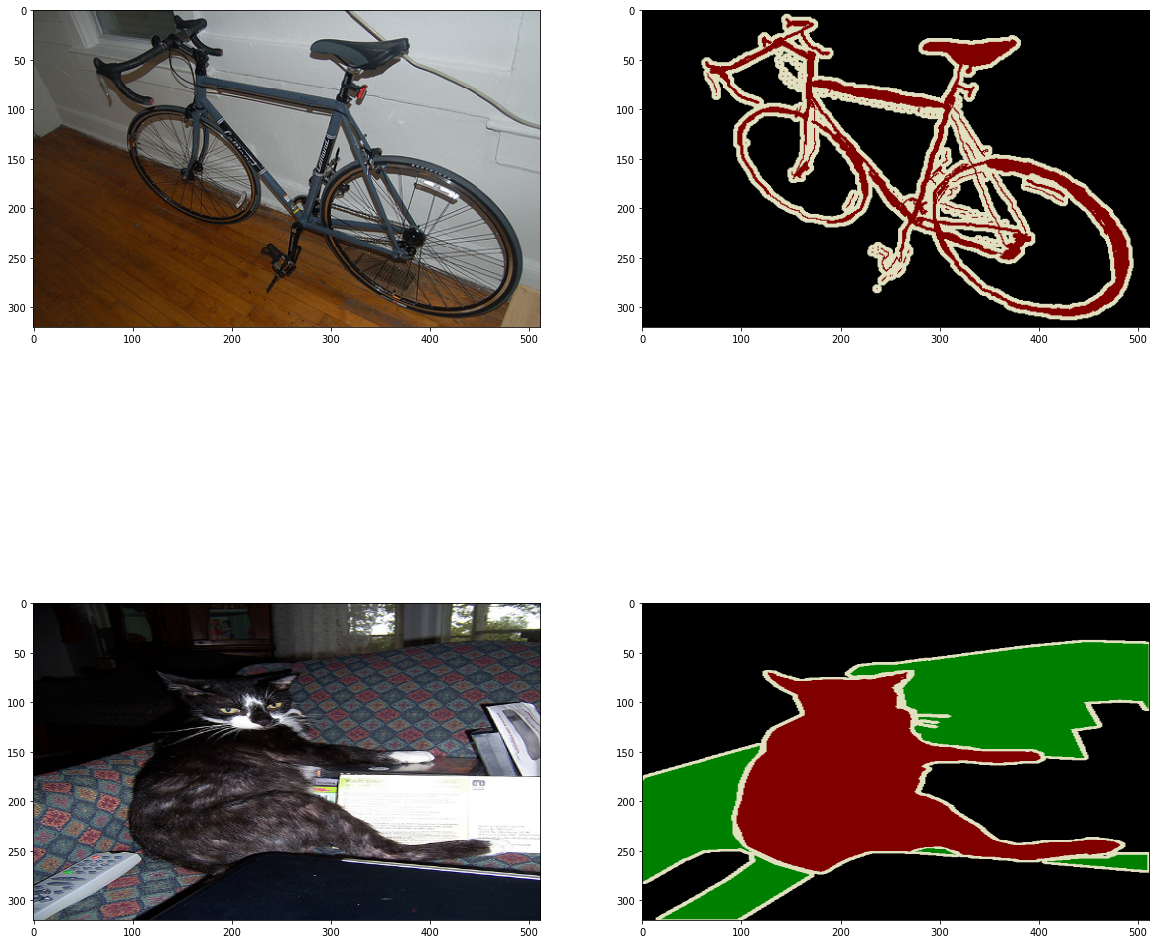

In [60]:
np.random.seed(seed)
batch_size = 2
training_generator = ImageGenerator(paths_train, train, 
                                    batch_size=batch_size, 
                                    input_size=(img_h, img_w, 3),
                                    output_size=(img_h, img_w, 3),
                                    resize_to=(img_h, img_w),
                                    shuffle=True)

example_batch = training_generator.__getitem__(0)
print "batch has length", len(example_batch)
print "batch has shape", example_batch[0].shape

# the batch has 2 elements: x and y
for i, img in enumerate(example_batch):
    print "img["+str(i)+"]", ims[i].shape


fig=pyplot.figure(figsize=(20,20))

for r in range(batch_size):
    for c in range(len(example_batch)):
        fig.add_subplot(batch_size, len(example_batch), 1+r*len(example_batch)+c)
        imshow(example_batch[c][r])


### 3. Segmentation using Fully Convolutional Neural Networks

In [27]:
# https://www.cv-foundation.org/openaccess/content_cvpr_2015/app/2B_011.pdf

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.constraints import maxnorm
from keras.optimizers import SGD, rmsprop
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D


def net_1(nr_channels, d1=None, d2=None):
    """
    # attempt building a network that does not care of the image structure
    """
    model = Sequential()
    model.add(Conv2D(16, (3, 3), 
                     input_shape=(d1, d2, nr_channels),
                     activation='relu', padding="same"))
    #model.add(MaxPooling2D((2, 2), padding="same"))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    #model.add(MaxPooling2D((2, 2), padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    #model.add(MaxPooling2D((2, 2), padding="same"))

    # ** encoded representation **
    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
    return model

def add_segnet_stage(model, net_depth, is_encoder=True, num_repetitions=2, is_first_layer=None, kernel_size=(7,7), up_down_sizing=(2,2)):
    if is_encoder:
        # an encoder stage is done as a 2DCNN repeated n times, and 1 Max Pooling layer at the end
        for i in range(num_repetitions):
            if is_first_layer is not None and i == 0:
                model.add(Conv2D(net_depth, kernel_size, input_shape=is_first_layer, activation='relu', padding='same'))
            else:
                model.add(Conv2D(net_depth, kernel_size, activation='relu', padding='same'))
            # batch normalization at the end of each convolution
            model.add(BatchNormalization())
        # (+1) max pooling to half the image size at the end of the stage
        model.add(MaxPooling2D(up_down_sizing, padding="same"))
    else:
        # a decoder stage is done as 1 UpSampling layer and a 2DCNN repeated n times
        # (1+) upsampling at the beginning of the stage
        model.add(UpSampling2D(up_down_sizing))
        for i in range(num_repetitions):
            model.add(Conv2D(net_depth, kernel_size, activation='relu', padding='same'))
            model.add(BatchNormalization())
    return model

def net_Segnet(nr_channels, img_h=None, img_w=None):
    """
        Return the Segnet from https://arxiv.org/pdf/1511.00561.pdf
    """
    model = Sequential()
    # ** ENCODER **
    # ---- stage 1 (2+1) ----
    model = add_segnet_stage(model, net_depth=64, is_encoder=True, num_repetitions=2, is_first_layer=(img_h, img_w, nr_channels))

    # ---- stage 2 (2+1) ----
    model = add_segnet_stage(model, net_depth=128, is_encoder=True, num_repetitions=2)
    # ---- stage 3 (3+1) ----
    model = add_segnet_stage(model, net_depth=256, is_encoder=True, num_repetitions=3)
    # ---- stage 4 (3+1) ----
    model = add_segnet_stage(model, net_depth=512, is_encoder=True, num_repetitions=3)
    # ---- stage 5 (3+1) ----
    model = add_segnet_stage(model, net_depth=512, is_encoder=True, num_repetitions=3)
    
    # ** DECODER **
    # ---- stage 1 (1+3) ----
    model = add_segnet_stage(model, net_depth=512, is_encoder=False, num_repetitions=3)
    # ---- stage 2 (1+3) ----
    model = add_segnet_stage(model, net_depth=512, is_encoder=False, num_repetitions=3)
    # ---- stage 3 (1+3) ----
    model = add_segnet_stage(model, net_depth=256, is_encoder=False, num_repetitions=3)
    # ---- stage 4 (1+2) ----
    model = add_segnet_stage(model, net_depth=128, is_encoder=False, num_repetitions=2)
    # ---- stage 5 (1+2) ----
    model = add_segnet_stage(model, net_depth=64, is_encoder=False, num_repetitions=2)
    
    # softmax layer at the end
    model.add(Conv2D(nr_channels, (3, 3), activation='softmax', padding='same'))
    model.add(BatchNormalization())
    return model


In [28]:
nr_channels = 3
model = net_Segnet(nr_channels, img_h=img_h, img_w=img_w)

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 320, 512, 64)      9472      
_________________________________________________________________
batch_normalization_1 (Batch (None, 320, 512, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 320, 512, 64)      200768    
_________________________________________________________________
batch_normalization_2 (Batch (None, 320, 512, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 160, 256, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 160, 256, 128)     401536    
_________________________________________________________________
batch_normalization_3 (Batch (None, 160, 256, 128)     512       
__________

### 4. Training the model

In [61]:
use_image_generator = True

In [62]:
np.random.seed(seed)
if train_using_generator:
    if use_image_generator:
        batch_size = 2
        epochs = 10
        training_generator = ImageGenerator(paths_train, train, batch_size=batch_size, 
                                            input_size=(img_h, img_w, 3),
                                            output_size=(img_h, img_w, 3),
                                            resize_to=(img_h, img_w),
                                            shuffle=True)
        validation_generator = ImageGenerator(paths_test, test, batch_size=batch_size, 
                                              input_size=(img_h, img_w, 3),
                                              output_size=(img_h, img_w, 3),
                                              resize_to=(img_h, img_w),
                                              shuffle=True)
        # Train model on dataset
        model.fit_generator(generator=training_generator,
                            validation_data=validation_generator,
                            epochs=epochs,
                            use_multiprocessing=True,
                            workers=6)
    else:
        batch_size = 2
        # train generator
        x_train_gen, y_train_gen = get_imageset_batch_generator(x_path=target_x_train, y_path=target_y_train,
                                                                resize_to=target_size,
                                                                batch_size=batch_size, seed=seed)
        train_generator = zip_xy_gens(x_train_gen, y_train_gen)
        # validation generator
        x_test_gen, y_test_gen = get_imageset_batch_generator(x_path=target_x_test, y_path=target_y_test,
                                                              resize_to=target_size,
                                                              batch_size=batch_size, seed=seed)
        test_generator = zip_xy_gens(x_test_gen, y_test_gen)

        model.fit_generator(train_generator,
                            steps_per_epoch=1,
                            validation_data=test_generator,
                            validation_steps=1,
                            #epochs=1,
                            #verbose=2
                           )
else:
    model.fit(x_train, 
              segmentation_obj_files_train,
              epochs=50,
              batch_size=128,
              shuffle=True,
              validation_data=(x_test, segmentation_obj_files_test))

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 4.5964e-08 - acc: 0.8896 - val_loss: 3.8371e-08 - val_acc: 0.7923
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: 1.4874e-08 - acc: 1.0000 - val_loss: 7.9200e-08 - val_acc: 0.6487
Epoch 3/10
1/1 [==============================] - 3s 3s/step - loss: 8.7142e-09 - acc: 0.9993 - val_loss: 1.9551e-08 - val_acc: 1.0000
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 2.5372e-08 - acc: 0.9357 - val_loss: 2.3879e-08 - val_acc: 1.0000
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 4.7239e-08 - acc: 0.8043 - val_loss: 2.8724e-08 - val_acc: 0.9753
Epoch 6/10
1/1 [==============================] - 3s 3s/step - loss: 2.6244e-08 - acc: 0.9246 - val_loss: 4.2177e-08 - val_acc: 0.8637
Epoch 7/10
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: 1.0205e-08 - acc: 0.9966 - val_loss: 2.6456e-08 - val_acc: 1.0000
Epoch 8/10
1/1 [============================

In [63]:
# Final evaluation of the model
np.random.seed(seed)
if not train_using_generator:
    scores = model.evaluate(x_test, segmentation_obj_files_test, verbose=0)
elif use_image_generator:
    validation_generator = ImageGenerator(paths_test, test, batch_size=batch_size, 
                                          input_size=(img_h, img_w, 3),
                                          output_size=(img_h, img_w, 3),
                                          resize_to=(img_h, img_w),
                                          shuffle=True)
    scores = model.evaluate_generator(validation_generator, steps=1)
else:
    scores = model.evaluate_generator(test_generator, steps=1) 
    #, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
    
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 100.00%


### 5. Example segmentation

test x (320, 512, 3)
test y (320, 512, 3)
segmented (1, 320, 512, 3)


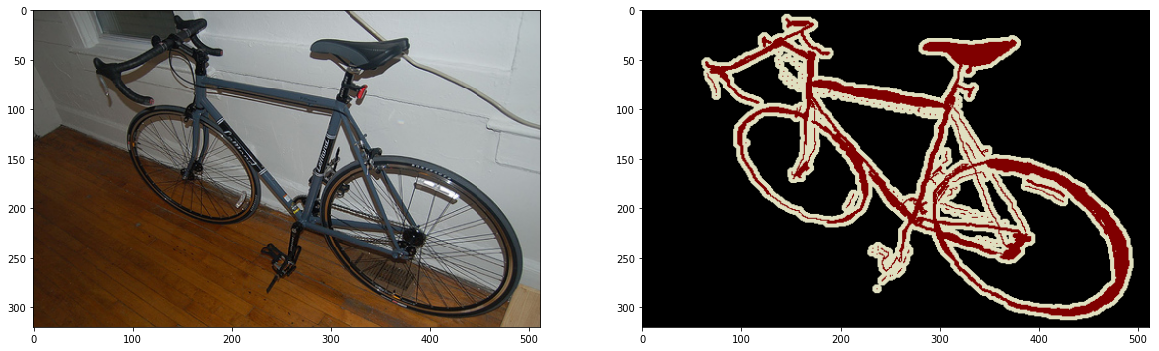

In [70]:
np.random.seed(seed)
if not train_using_generator:
    segmented = model.predict(
        # only predict the first element as example
        np.reshape(x_test[0], (1, img_h, img_w, 3))
    )

    pyplot.imshow(
        np.reshape(x_test[0], (1, img_h, img_w, 3))[0]
    )
elif use_image_generator:
    batch_size = 1
    training_generator = ImageGenerator(paths_train, train, 
                                        batch_size=batch_size, 
                                        input_size=(img_h, img_w, 3),
                                        output_size=(img_h, img_w, 3),
                                        resize_to=(img_h, img_w),
                                        shuffle=True)

    example_batch = training_generator.__getitem__(0)
    # the batch has 2 elements: x and y
    print "test x", example_batch[0][0].shape
    print "test y", example_batch[1][0].shape

    segmented = model.predict(
        # only predict the first element as example
        example_batch[0]
        #np.reshape(     example_batch[0], (1, img_h, img_w, 3))
    )
    print "segmented", segmented.shape

    fig=pyplot.figure(figsize=(20,20))

    for r in range(batch_size):
        for c in range(len(example_batch)):
            fig.add_subplot(batch_size, len(example_batch), 1+r*len(example_batch)+c)
            imshow(example_batch[c][r])
else:
    pass

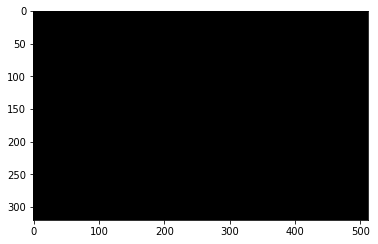

In [72]:
if not train_using_generator:
    pyplot.imshow(
        np.reshape(segmented, (1, img_h, img_w, 3))[0]
    )
elif use_image_generator:
    pyplot.imshow(
        np.reshape(segmented, (1, img_h, img_w, 3))[0]
    )
else:
    pass